## Overview

This project predicts related rates with deep learning methods.

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import json
import time
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import pickle

#import geopandas as gpd

In [3]:
%%capture
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
tqdm().pandas()

# Data Collection

## Coronavirus API

https://www.programmableweb.com/api/coronavirus-tracker-rest-api-v20

In [2]:
url = 'https://coronavirus-tracker-api.herokuapp.com/v2/locations'

random = np.random.uniform(0, 1, 501)
# time.sleep(random[i])
params = {  
            #'source': 'csbs',
            #'country_code': 'US',           
            'timelines': 1
          }

response = requests.get(url, params)
d = response.json()

In [15]:
d['locations'][248]

{'id': 248,
 'country': 'Turkey',
 'country_code': 'TR',
 'country_population': 82319724,
 'province': '',
 'last_updated': '2021-01-27T15:00:34.609843Z',
 'coordinates': {'latitude': '38.9637', 'longitude': '35.2433'},
 'latest': {'confirmed': 2442350, 'deaths': 25344, 'recovered': 0}}

In [3]:
ts = pd.DataFrame(d['locations'][248]['timelines']['deaths'])

In [4]:
ts.index = pd.to_datetime(ts.index).date

# ARIMA

In [51]:
from statsmodels.tsa.arima_model import ARIMA
import warnings

model = ARIMA(ts, order=(1,2,3))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/Users/mbcn345/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/mbcn345/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided,

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

<AxesSubplot:>

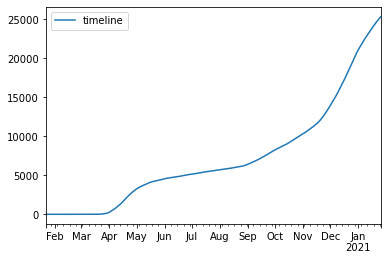

In [35]:
ts.plot()

# Prophet

In [5]:
from fbprophet import Prophet

In [6]:
import fbprophet

In [7]:
fbprophet.__version__

'0.7.1'

In [26]:
ts.index.name = 'ds'
ts = ts.reset_index()
ts = ts.rename(columns={'timeline': 'y'})

In [27]:
Model = Prophet(interval_width=0.95)
Model.fit(ts)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
future_dates = Model.make_future_dataframe(periods=30, freq='D')
future_dates.tail()

,ds
396,2021-02-21
397,2021-02-22
398,2021-02-23
399,2021-02-24
400,2021-02-25


In [29]:
forecast = Model.predict(future_dates)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,-9.257413,-364.547889,352.641914,-9.257413,-9.257413,3.252063,3.252063,3.252063,3.252063,3.252063,3.252063,0.0,0.0,0.0,-6.005350
1,2020-01-23,-9.051921,-330.679996,348.737192,-9.051921,-9.051921,5.321936,5.321936,5.321936,5.321936,5.321936,5.321936,0.0,0.0,0.0,-3.729985
2,2020-01-24,-8.846429,-338.003886,329.736907,-8.846429,-8.846429,3.620696,3.620696,3.620696,3.620696,3.620696,3.620696,0.0,0.0,0.0,-5.225733
3,2020-01-25,-8.640936,-348.355099,331.868003,-8.640936,-8.640936,0.646546,0.646546,0.646546,0.646546,0.646546,0.646546,0.0,0.0,0.0,-7.994390
4,2020-01-26,-8.435444,-346.592119,311.619874,-8.435444,-8.435444,-2.546229,-2.546229,-2.546229,-2.546229,-2.546229,-2.546229,0.0,0.0,0.0,-10.981673


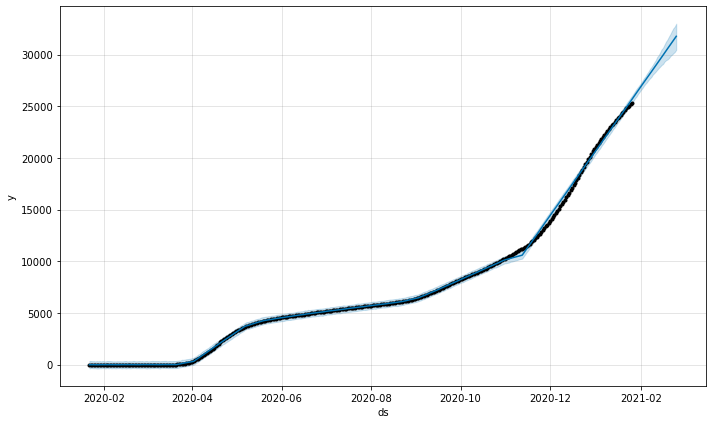

In [30]:
Model.plot(forecast, uncertainty=True)
plt.show()

<AxesSubplot:>

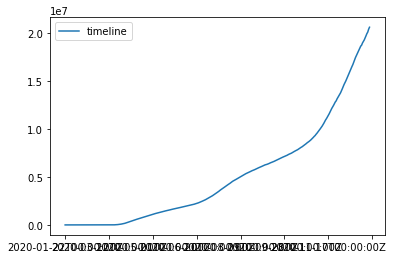

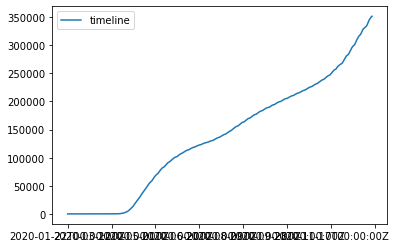

In [54]:
pd.DataFrame(d['locations'][248]['timelines']['confirmed']).plot()
pd.DataFrame(d['locations'][248]['timelines']['deaths']).plot()

In [74]:
df = pd.DataFrame(d['locations'])

In [75]:
df

,id,country,country_code,country_population,province,county,last_updated,coordinates,latest
0,0,US,US,327167434,California,Los Angeles,2021-01-04T13:31:00Z,"{'latitude': '34.053490000000004', 'longitude'...","{'confirmed': 818698, 'deaths': 10773, 'recove..."
1,1,US,US,327167434,California,San Bernardino,2021-01-04T13:31:00Z,"{'latitude': '34.10524', 'longitude': '-117.29...","{'confirmed': 195663, 'deaths': 1447, 'recover..."
2,2,US,US,327167434,California,Riverside,2021-01-04T13:31:00Z,"{'latitude': '33.98171', 'longitude': '-117.37...","{'confirmed': 180553, 'deaths': 1985, 'recover..."
3,3,US,US,327167434,California,San Diego,2021-01-04T13:31:00Z,"{'latitude': '32.71568', 'longitude': '-117.16...","{'confirmed': 168020, 'deaths': 1592, 'recover..."
4,4,US,US,327167434,California,Orange,2021-01-04T13:31:00Z,"{'latitude': '33.78787', 'longitude': '-117.85...","{'confirmed': 161589, 'deaths': 1901, 'recover..."
...,...,...,...,...,...,...,...,...,...
3151,3151,US,US,327167434,US Virgin Islands,St. Thomas,2021-01-04T13:31:00Z,"{'latitude': '18.34899', 'longitude': '-64.930...","{'confirmed': 1028, 'deaths': 0, 'recovered': 0}"
3152,3152,US,US,327167434,US Virgin Islands,St. Croix,2021-01-04T13:31:00Z,"{'latitude': '17.73563', 'longitude': '-64.747...","{'confirmed': 829, 'deaths': 0, 'recovered': 0}"
3153,3153,US,US,327167434,US Virgin Islands,St. John,2021-01-04T13:31:00Z,"{'latitude': '18.33870409', 'longitude': '-64....","{'confirmed': 174, 'deaths': 0, 'recovered': 0}"
3154,3154,US,US,327167434,Northern Mariana Islands,Northern Mariana Islands,2021-01-04T13:31:00Z,"{'latitude': '15.188824770000052', 'longitude'...","{'confirmed': 31, 'deaths': 2, 'recovered': 0}"


## API

https://covidtracking.com/data/api

In [194]:
url = 'https://api.covidtracking.com/v1/us/daily.json'

response = requests.get(url)
d = response.json()

In [195]:
pd.DataFrame(d)

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,totalTestResults,lastModified,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,hash
0,20210104,56,20560549.0,198034096.0,9463.0,128210.0,699971.0,23435.0,37586.0,7930.0,...,256914140,2021-01-04T24:00:00Z,0,0,1545,4029,1257838,177669,1638082,9a5d7bba3805b8932e540b0cfbc0ce782ef9b94c
1,20210103,56,20382880.0,196776258.0,9407.0,125562.0,695942.0,23243.0,37433.0,7939.0,...,255276058,2021-01-03T24:00:00Z,0,0,1461,2226,1001197,207726,1444369,fd495d4591df97f8297b69a93a38209da53a5d30
2,20210102,56,20175154.0,195775061.0,9356.0,123614.0,693716.0,23133.0,37309.0,7910.0,...,253831689,2021-01-02T24:00:00Z,0,0,2395,3051,1358739,278680,2077336,0a41916c227cf908081548d26fcad961a5f00397
3,20210101,56,19896474.0,194416322.0,11506.0,125047.0,690665.0,23255.0,37196.0,7990.0,...,251754353,2021-01-01T24:00:00Z,0,0,2596,4507,872785,179852,1276261,7641ed39d70f7ed6a52a1068b5c36f6c91c8d190
4,20201231,56,19716622.0,193543537.0,14931.0,125379.0,686158.0,23099.0,37066.0,8003.0,...,250478092,2020-12-31T24:00:00Z,0,0,3287,4290,1120447,223036,1748878,87a8179b8e103555fec80788c35221afd086662a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,20200117,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,2020-01-17T24:00:00Z,0,0,0,0,0,0,0,5fd7ed7fb0f83565ea0aaaf5ff6104e5860be2d6
354,20200116,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,2020-01-16T24:00:00Z,0,0,0,0,0,0,0,4c0f2ea879eefec1a18a93bcd8a382ea56cd452d
355,20200115,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,2020-01-15T24:00:00Z,0,0,0,0,0,0,0,8a449023413eea473277416e9e30ae126c6af047
356,20200114,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,2020-01-14T24:00:00Z,0,0,0,0,0,0,0,fe399466a3dfbe0221a18ed5cacb39a3882d72f8


In [196]:
url = 'https://api.covidtracking.com/v1/us/current.json'

response = requests.get(url)
d = response.json()

In [197]:
d

[{'date': 20210104,
  'states': 56,
  'positive': 20560549,
  'negative': 198034096,
  'pending': 9463,
  'hospitalizedCurrently': 128210,
  'hospitalizedCumulative': 699971,
  'inIcuCurrently': 23435,
  'inIcuCumulative': 37586,
  'onVentilatorCurrently': 7930,
  'onVentilatorCumulative': 3692,
  'recovered': 8299717,
  'dateChecked': '2021-01-04T24:00:00Z',
  'death': 344808,
  'hospitalized': 699971,
  'totalTestResults': 256914140,
  'lastModified': '2021-01-04T24:00:00Z',
  'total': 0,
  'posNeg': 0,
  'deathIncrease': 1545,
  'hospitalizedIncrease': 4029,
  'negativeIncrease': 1257838,
  'positiveIncrease': 177669,
  'totalTestResultsIncrease': 1638082,
  'hash': '9a5d7bba3805b8932e540b0cfbc0ce782ef9b94c'}]

In [202]:
#url = 'https://api.covidtracking.com/v1/us/20200501.json'
url = 'https://api.covidtracking.com/v1/states/daily.json'

response = requests.get(url)
d = response.json()

In [204]:
pd.DataFrame(d)

,date,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20210104,AK,46812.0,NaN,1250686.0,NaN,totalTestsViral,1297498.0,97.0,1033.0,...,1297498,3,0,38c46f0e7665bfa2a088389162ae643ab0f7c47b,0,0,0,0,0,
1,20210104,AL,374095.0,72609.0,1601902.0,NaN,totalTestsPeopleViral,1903388.0,3064.0,35430.0,...,1975997,5,1057,3a5911f450cc081cc151cac160ab040d8b156402,0,0,0,0,0,
2,20210104,AR,234781.0,41126.0,1901966.0,NaN,totalTestsViral,2095621.0,1296.0,11514.0,...,2136747,51,0,c68de0e9a5cf79ae4a90e113ba1f80a7484916e7,0,0,0,0,0,
3,20210104,AS,0.0,NaN,2140.0,NaN,totalTestsViral,2140.0,NaN,NaN,...,2140,0,0,ab3d7aae8a16bba4952e91bfe530f31564a0ee9e,0,0,0,0,0,
4,20210104,AZ,561542.0,28267.0,2404314.0,NaN,totalTestsViral,5288658.0,4647.0,39897.0,...,2965856,3,169,a68db19ed7c33ed6c1b432cc88bea654e40710b6,0,0,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17262,20200117,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,0,0,0,effcc7b17054638471dec2f2a9cdbd3229d92042,0,0,0,0,0,
17263,20200116,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,0,0,0,d9453d58f00994cff1f81639e95e532d1dd10138,0,0,0,0,0,
17264,20200115,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,0,0,0,bd1eef4afdffd883e37be1d3f321dc3b0e75f591,0,0,0,0,0,
17265,20200114,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,0,0,0,84aeea9c6a284b151fdb42a863db3c0aadb651bf,0,0,0,0,0,


In [209]:
df = pd.read_excel('default of credit card clients.xls',  index_col=0, header=1)

In [214]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [215]:
df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1


## API

https://cord19.vespa.ai

## Zip API

https://www.programmableweb.com/api/zip-api-us

In [133]:
from requests.auth import HTTPBasicAuth

In [ ]:
f = open('api.json')
api_key = json.load(f)

In [164]:
url = f"https://service.zipapi.us/hospital/radius/11367?X-API-KEY={api_key['zip_api']['api']}"

params = {  
            'radius': 20
          }

response = requests.get(url, params,  auth=HTTPBasicAuth(api_key['zip_api']['email'], api_key['zip_api']['password']))
d = response.json()

In [169]:
pd.DataFrame(d['data'])

,Zip,Name,Address,City,State,telephone,latitude,longitude,website,beds,naics_desc,helipad,population,county,distance
0,11355,NEW YORK HOSPITAL QUEENS,56 45 MAIN ST,FLUSHING,NY,(718) 670-2000,40.7467722760001,-73.8254163829999,http://www.nyhq.org/,519,GENERAL MEDICAL AND SURGICAL HOSPITALS,N,519,QUEENS,1.2056043406980474
1,11375,FOREST HILLS HOSPITAL,102-01 66 ROAD,FOREST HILLS,NY,(516) 562-4060,40.7289946700001,-73.8515067069999,https://www.northwell.edu/find-care/locations/...,222,GENERAL MEDICAL AND SURGICAL HOSPITALS,N,222,QUEENS,1.2667295458905368
2,11432,QUEENS HOSPITAL CENTER,82-68 164TH ST,JAMAICA,NY,(718) 883-2350,40.7170722130001,-73.804556192,http://www.nyc.gov/html/hhc/qhc/html/home/home...,247,GENERAL MEDICAL AND SURGICAL HOSPITALS,N,247,QUEENS,1.464323443176699
3,11355,FLUSHING HOSPITAL MEDICAL CENTER,45 TH AVE & PARSONS BLVD,FLUSHING,NY,(718) 670-5918,40.7554099230001,-73.816465518,http://www.flushinghospital.org,293,GENERAL MEDICAL AND SURGICAL HOSPITALS,N,293,QUEENS,1.8859069570899702
4,11414,JAMAICA HOSPITAL MEDICAL CENTER,8900 VAN WYCK EXPRESSWAY,JAMAICA,NY,(718) 206-6000,40.700103647,-73.816114892,http://jamaicahospital.org/,408,GENERAL MEDICAL AND SURGICAL HOSPITALS,N,408,QUEENS,2.1063832945759255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,07107,COLUMBUS HOSPITAL,495 NORTH 13TH STREET,NEWARK,NJ,(973) 587-7712,40.772604012,-74.1867090869999,http://www.columbusltach.org,63,SPECIALTY (EXCEPT PSYCHIATRIC AND SUBSTANCE AB...,N,63,ESSEX,19.046704035393592
118,07103,THE UNIVERSITY HOSPITAL,150 BERGEN STREET,NEWARK,NJ,(973) 972-5658,40.740603133,-74.191061732,http://www.uhnj.org/,519,GENERAL MEDICAL AND SURGICAL HOSPITALS,Y,519,ESSEX,19.05932172210713
119,10522,ST. JOHN'S RIVERSIDE HOSPITAL - DOBBS FERRY,128 ASHFORD AVE,DOBBS FERRY,NY,(914) 693-0700,41.014392248,-73.861919649,http://www.riversidehealth.org,12,GENERAL MEDICAL AND SURGICAL HOSPITALS,N,12,WESTCHESTER,19.775034789331748
120,07652,BERGEN REGIONAL MEDICAL CENTER,230 EAST RIDGEWOOD AVENUE,PARAMUS,NJ,(201) 967-4000,40.956667775,-74.0629917159999,http://www.bergenregional.com,510,GENERAL MEDICAL AND SURGICAL HOSPITALS,N,510,BERGEN,19.95883250040654


In [181]:
url = f"https://service.zipapi.us/age/zipcode/11367?X-API-KEY={api_key['zip_api']['api']}"

# params = {  
#             'fields': ['male_age','female_age']
#           }

response = requests.get(url, params,  auth=HTTPBasicAuth(api_key['zip_api']['email'], api_key['zip_api']['password']))
d = response.json()

In [182]:
d

{'status': True,
 'data': {'median_age': '34.2', 'male_age': '32.1', 'female_age': '36.3'}}

## Web Scraping

# Data Clean and Analysis

# Visualization

# Conclusion